# Exercise 5
### By Gruppe H (Caroline og Maria)

In [1]:
#!pip install streamlit

In [ ]:
#!streamlit hello

In [3]:
#!pip install langchain

In [4]:
#!pip install langdetect

In [5]:
#!pip install -U torch

## Set up Enviroment 

In [6]:
import os
import pandas as pd

In [7]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [8]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [9]:

from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [10]:
# Embedding facilities
from langchain.embeddings import HuggingFaceEmbeddings

In [11]:
# Pipelines
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

## Load Documents
Our first task is to collect and load documents from various sources and formats in the context of our chosen domain, which is **knitting for beginners**.

We have chosen to load content from pdf files, YouTube and Wikipedia.

In [12]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [13]:
import importlib 
importlib.reload(myloadlib)

<module 'myloadlib' from '/Users/mariamcnally/Desktop/SW2Semester/AI/OLA5/myloadlib.py'>

In [14]:
# Collect all here
documents = []

### Load single pdf files

#### File 1

In [15]:
file = "./data/knitting_pdfs/knit.pdf"

In [16]:
#!pip install pypdf

In [17]:
docs = myloadlib.loadFile(file)

In [18]:
documents.extend(docs)
len(documents)

21

In [19]:
# metadata of loaded Document
docs[0].metadata 

{'source': './data/knitting_pdfs/knit.pdf', 'page': 0}

Content of page [0] = page 1. 

In [20]:
documents[0].page_content
#docs[0].page_content[:1000]
# First 1000 charactors.

' \n \nBeginning Knitting  \n \nWHAT IS KNITTING? \n \nHand knitting is to make fabric with yarn \non two or more needles.  A number of loops are first made on one needle, and then the fabric "grows\'\' by drawing other loops through them as they are passed back and forth along the needles from row to row. \n \nAll knitting comes from two kinds of stitches. One is called a "knit stitch," and the other is called a "purl stitch." There \nare several different ways or methods of knitting. Refer to directions in the pattern/instructions for explanations and types of stitches required.  \n \nKnitting can produce something useful, but the process can,  and should be, fun \nand relaxing.  The main thing is to learn to enjoy  knitting—relax while you work, \navoid a cramped position, have a good light to see by, and if your hands become tired, stop and rest a while.  \nHistory of Knitting \n \nKnitting is older than written history. No \none knows exactly when people began to knit, but we do k

#### File 2

In [21]:
file2 = "./data/knitting_pdfs/knitting-handbook.pdf"

In [22]:
docs = myloadlib.loadFile(file2)

In [23]:
documents.extend(docs)
len(documents)

61

In [24]:
docs[1].metadata 

{'source': './data/knitting_pdfs/knitting-handbook.pdf', 'page': 1}

In [25]:
documents[1].page_content

' 2 \nAll knitting patterns tell you the size of \nneedles you will need. Never discard your needles when you have fini shed the project.  \nIf you lose one needle and have to buy another pair the same size, keep the extra \nneedle. You never know when you may lose or break another one.   \n \n\x88    Crochet Hook  \nYou will need a crochet hook to pick \nup dropped stitches and to correct other mistakes. They also come in many sizes. Size C, or 6, is a good one for 4-ply knitting yarn. \n \n\x88    Measuring Tool  \nYou will need a measuring tool. You \ncan use a ruler, a measuring tape, or a metal measuring gauge. Be sure your \nmeasuring tool has both standard and \nmetric measurements. \n \n \n \n  \n\x88 Other helpful items: \n \nScissors  -    You will also want to \ninclude in your knitting basket a pair of small scissors (kept in a case for safety). \n \nYarn needle  -  a blunt-pointed yarn \nneedle for sewing your articles together. \n  Nail file or emery board   -  for catchy

### Load YouTube

In [26]:
url = 'https://www.youtube.com/watch?v=Zjq0MoUZqVY'
save_dir="./youtube/"

In [27]:
url

'https://www.youtube.com/watch?v=Zjq0MoUZqVY'

In [28]:
lang = 'en'

In [29]:
#!pip install youtube-transcript-api

In [30]:
#!pip install pytube

In [31]:
docs = myloadlib.loadYoutube(url, lang)

In [32]:
documents.extend(docs)
len(documents)

62

In [33]:
documents[61].type

'Document'

In [34]:
documents[61].page_content

"In, around, under and off. You'll\xa0 be dreaming this by the end. Hello knitters, i'm Marion from Lovecrafts\xa0 and I'm going to show you how to knit. Now, in this video we're going to do a\xa0little project where we start knitting\xa0from start to finish.  This is the little\xa0swatch we're going to knit. I'm going to\xa0show you how to start, how to cast on, how to knit this lovely knit stitch\xa0\xa0 and then how to cast off. So, it's everything\xa0 in one go.  Now if you learn to make one of these, you can make a scarf or a cushion cover or\xa0a pillow or a blanket - anything at all! \xa0 So, this is a really good tutorial just for some basic\xa0ground work before you start your knitting. So, I'm going to use Paint Box wool mix super chunky.\xa0And the reason i'm using a super chunky yarn\xa0\xa0 is because when you start knitting it's really\xa0important to be able to see the stitches.  Um, and so I always prefer to use a big yarn, and that way your\xa0work grows very fast, so 

### Load wikipedia page

In [35]:
subject = "Knitting"

In [36]:
lang = 'en'

In [37]:
#!pip install wikipedia

In [38]:
docs = myloadlib.loadWiki(subject, lang, 2)

In [39]:
documents.extend(docs)

Should be 4 at the moment, but will update everytime its run, and or other Docs/documents are ran again

In [40]:
len(documents)

64

## Chunking
Now we will be chunking our documents, which means breaking down our texts into smaller, more manageable chunks to prepare it for AI processing.

In [41]:
#!pip install spacy
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.0.0/en_core_web_md-3.0.0.tar.gz

In [42]:
#!pip install wordcloud

In [43]:
import myutils2
from myutils2 import chunkDocs, langDetect, wordCloud

In [44]:
import importlib 
importlib.reload(myutils2)

<module 'myutils2' from '/Users/mariamcnally/Desktop/SW2Semester/AI/OLA5/myutils2.py'>

In [45]:
splits = myutils2.chunkDocs(documents, 350)  
splits

[Document(page_content='Beginning Knitting  \n \nWHAT IS KNITTING? \n \nHand knitting is to make fabric with yarn \non two or more needles.  A number of loops are first made on one needle, and then the fabric "grows\'\' by drawing other loops through them as they are passed back and forth along the needles from row to row.', metadata={'source': './data/knitting_pdfs/knit.pdf', 'page': 0}),
 Document(page_content='All knitting comes from two kinds of stitches. One is called a "knit stitch," and the other is called a "purl stitch." There \nare several different ways or methods of knitting. Refer to directions in the pattern/instructions for explanations and types of stitches required.', metadata={'source': './data/knitting_pdfs/knit.pdf', 'page': 0}),
 Document(page_content='Knitting can produce something useful, but the process can,  and should be, fun \nand relaxing.  The main thing is to learn to enjoy  knitting—relax while you work, \navoid a cramped position, have a good light to se

In [46]:
len(splits)

394

In [47]:
splits[70]

Document(page_content='technique is called binding off.  \nProcedure \n \n1. Slip the first stitch  on the row off the left \nneedle onto the right  needle without \nknitting. \n \n2. Knit the next stitch very loosely. There \nare now two stitches on the right needle. \n \n3. Insert the left needle through the left \nside of the first stitch.', metadata={'source': './data/knitting_pdfs/knit.pdf', 'page': 9})

In [48]:
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(3)

,page_content,metadata,type
306,"(page_content, decisions. Utah State Universi...","(metadata, {'source': './data/knitting_pdfs/kn...","(type, Document)"
13,"(page_content, Case for needles and hooks - \...","(metadata, {'source': './data/knitting_pdfs/kn...","(type, Document)"
97,"(page_content, out on the right side, insert i...","(metadata, {'source': './data/knitting_pdfs/kn...","(type, Document)"


In [49]:
df['page_content'][0]

('page_content',
 'Beginning Knitting  \n \nWHAT IS KNITTING? \n \nHand knitting is to make fabric with yarn \non two or more needles.  A number of loops are first made on one needle, and then the fabric "grows\'\' by drawing other loops through them as they are passed back and forth along the needles from row to row.')

In [50]:
df['metadata'][0]

('metadata', {'source': './data/knitting_pdfs/knit.pdf', 'page': 0})

In [51]:
#!pip install scapy

In [52]:
#!bash
#!python3 -m spacy download en_core_web_md

### Data Visualization
To visually represent the data of our texts, we have created a word cloud. On the word cloud, we can see which words apear more frequently as they appear bigger.

In [53]:
im, longstring = myutils2.wordCloud(df, 'page_content')

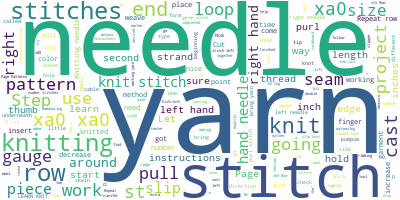

In [54]:
im

## Embeddings

In [55]:
model_name = "sentence-transformers/all-mpnet-base-v2"
# model_name = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [56]:
#!pip install sentence-transformers

In [57]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
from langchain.vectorstores import FAISS

In [59]:
#!pip install faiss-cpu

In [60]:
db = FAISS.from_documents(splits, embeddings)

## Storing the Embeddings in Vector DB

In [61]:
#!pip install chromadb

In [62]:
db = Chroma.from_documents(splits, embeddings)

In [63]:
persist_directory = '../data/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [64]:
vectordb._collection.count()

2009

## Similarity Search

In [65]:
query = 'what is the best yarn for beginners?'

In [66]:
answer = vectordb.similarity_search(query, k=3)
answer

[Document(page_content='Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply \nworsted hand knitting yarn is \nrecommended for beginning knitters . \n \nWhen a knitted garment is designed, the', metadata={'page': 3, 'source': './data/knitting_pdfs/knit.pdf'}),
 Document(page_content='Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply \nworsted hand knitting yarn is \nrecommended for beginning knitters . \n \nWhen a knitted garment is designed, the', metadata={'page': 3, 'source': './data/knitting_pdfs/knit.pdf'}),
 Document(page_content='Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply \nworsted hand knitting yarn is \nrecommended for beginning knitters

In [67]:
for d in answer:
    print(d.page_content)

Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply 
worsted hand knitting yarn is 
recommended for beginning knitters . 
 
When a knitted garment is designed, the
Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply 
worsted hand knitting yarn is 
recommended for beginning knitters . 
 
When a knitted garment is designed, the
Hand knitting yarn of acrylic, wool, or wool/nylon is suitable for hats, mittens, gloves, sweaters, and scarves. Because of its firm twist and medium weight, 4-ply 
worsted hand knitting yarn is 
recommended for beginning knitters . 
 
When a knitted garment is designed, the


In [68]:
for d in answer:
    print(d.metadata)

{'page': 3, 'source': './data/knitting_pdfs/knit.pdf'}
{'page': 3, 'source': './data/knitting_pdfs/knit.pdf'}
{'page': 3, 'source': './data/knitting_pdfs/knit.pdf'}


## Information Retrieval

In [69]:
q1 = 'What does "K2tog" mean?'

In [70]:
q2 = 'What are stitch markers and how do I use them?'

In [71]:
q3 = 'How do I cast on stitches?'

In [72]:
q4 = "What's the difference between circular needles and straight needles?"

In [73]:
answer = vectordb.max_marginal_relevance_search(q1, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

CO  cast on 
dec  decrease 
dk double knitting --both a yarn size 
and a knitting technique 
dpn(s)   double pointed needle(s) 
FC or CF  front cross 
g or gr   gram(s) 
g st  garter stitch 
in(s)   inch(es) 
inc  increase 
k  knit 
k2tog   knit two together 
  (a right slanted decrease) 
kf&b  knit in front and back of stitch (a way
CO  cast on 
dec  decrease 
dk double knitting --both a yarn size 
and a knitting technique 
dpn(s)   double pointed needle(s) 
FC or CF  front cross 
g or gr   gram(s) 
g st  garter stitch 
in(s)   inch(es) 
inc  increase 
k  knit 
k2tog   knit two together 
  (a right slanted decrease) 
kf&b  knit in front and back of stitch (a way


In [74]:
answer = vectordb.max_marginal_relevance_search(q2, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

30• Following 2 rows: Work even in stockinette stitch.
• Thumb Row 1: K across to the second marker; remove the marker; place the remaining 
13, (14,17, 22) sts on a stitch holder; cast on 2 sts on the right hand needle for the base of  the thumb.
• Following rows: P the 2 cast-on sts; p the next 8 (8, 12, 12) sts; remove the other marker; place
marker; inc one st in the next st; k to the end of  the row. There are now 6 sts between markers.• Repeat rows 2 and 3: Work even in stockinette stitch.PATTERNS: 
MITTENS
The pattern is designed for striped mittens. You may choose to make yours in


In [75]:
answer = vectordb.max_marginal_relevance_search(q3, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

There are several methods of casting on stitches. One method is shown here. By using two yarns to cast  on, the beginning or 
edge of your work will be stronger.
There are several methods of casting on stitches. One method is shown here. By using two yarns to cast  on, the beginning or 
edge of your work will be stronger.


In [76]:
answer = vectordb.max_marginal_relevance_search(q4, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

points. Be careful with them and learn to 
use them properly. It is a good idea to put protectors on the tips when you put your 
work down. Protectors keep the points from 
sticking people and prevent stitches from slipping off  the needles. Use rubber tips made
under, and off.  Just say that to yourself. There we go. In, around, under and off. Now, you know, it doesn't matter how you hold your needles. So, some people - I'm holding them like this in a face with open palms. You might find it's easier if you hold your needles this way.  So, you might find it easier with your hand on top.  So, if I try that


## Large Language Model

In [104]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [105]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED       
mistral:latest	61e88e884507	4.1 GB	10 seconds ago	
llama3:latest 	a6990ed6be41	4.7 GB	47 minutes ago	


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [106]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [107]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use five sentences maximum. Keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer. 

{context}

Question: {question}

Helpful Answer:
"""

In [108]:
prompt = PromptTemplate.from_template(template)
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [109]:
question1 = 'What does "K2tog" mean?'

In [110]:
result1 = chain({"query": question1})
result1["result"]

 "K2tog" is a knitting term that means "knit two stitches together." This creates a decrease by joining two stitches into one. Thanks for asking!

' "K2tog" is a knitting term that means "knit two stitches together." This creates a decrease by joining two stitches into one. Thanks for asking!'

In [111]:
question2 = 'What are stitch markers and how do I use them?'

In [128]:
result2 = chain({"query": question2})

 Stitch markers are small tools used to indicate specific stitches or areas in a knitting or crocheting project. In the provided context, they are used to mark the beginning of the thumb section in a pattern. To use them, follow these steps:

1. Insert a stitch marker into the live stitch before the specified point.
2. Knit or crochet past the marker.
3. When you reach the marker again, remove it.
4. Repeat the process for other markers as needed.
5. Place marked stitches on a stitch holder when instructed to do so in a pattern.

Thanks for asking!

In [113]:
question3 = 'How do I cast on stitches?'

In [127]:
result3 = chain({"query": question3})

 One method of casting on stitches involves using two yarns. This method creates a stronger edge for your work. To do this, follow the steps shown in the provided visuals. Thanks for asking!

In [115]:
question4 = "What's the difference between circular needles and straight needles?"

In [125]:
result4 = chain({"query": question4})

 Circular needles have a joined tip, creating a continuous loop for knitting in the round. Straight needles have separate tips. Circular needles use protectors to prevent sticking and keep stitches on, while straight needles require using stitch markers or joining new stitches. Using each type appropriately depends on your project needs. Thanks for asking!

In [117]:
question5 = 'What does water taste like?'

In [124]:
result5 = chain({"query": question5})

 Water is tasteless and odorless in its pure form. Humans don't have a specific taste receptor for water, as we perceive it as lacking any distinct flavor. Thanks for asking!

In [119]:
question6 = 'what color pants do i have on?'

In [123]:
result6 = chain({"query": question6})

 I'm sorry, but the context provided does not include any information about the color of your pants. Thanks for asking!

In [ ]:
## make a steamlit application